In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from dataset import get_dataset, get_pokemon
from utils import alphabar_t
# from model import Model
from generate import train_sample
from model import Unet
import os

torch.backends.cudnn.benchmark = True


/home/bigbrainman/deepvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 500
S = 0.0008
BATCH_SIZE = 16
IMAGE_SIZE = 128
CHANNELS = 3
SPLIT = 'digits'
MODEL_DIR = './models2'
SAMPLE_DIR = './samples2'

ITERS_PRINT = 20
ITERS_GENERATE = 100



In [3]:
# train_set = get_dataset(T, image_size=IMAGE_SIZE, split=SPLIT)
train_set = get_pokemon(T, image_size=IMAGE_SIZE, path='./data/pokemon/pokemon_jpg/')

In [4]:
len(train_set)

819

In [5]:
g = make_grid([train_set[random.randint(0, len(train_set) -1)][2] for _ in range(25)], 5)

torch.Size([3, 128, 128])


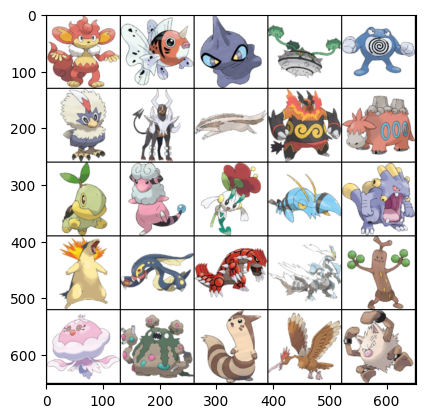

In [6]:
plt.imshow(g.permute(1, 2, 0))
print(train_set[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


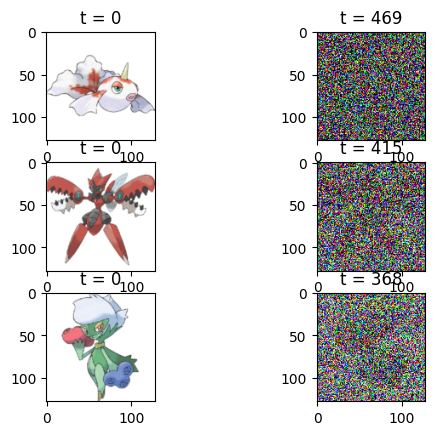

In [7]:
fig, axes = plt.subplots(3, 2)

for i in range(3):
    idx = random.randint(1, T - 1)
    axrow = axes[i]

    noise_img, eps, img, t = train_set[idx]

    axrow[0].imshow(img.permute(1, 2, 0), cmap='gray')
    axrow[0].set_title('t = 0')

    axrow[1].imshow(noise_img.permute(1, 2, 0), cmap='gray')
    axrow[1].set_title(f"t = {t}")

In [8]:
# net = Model(u_depth = 5, block_size=3, h_channels = 10).to(device)


net = Unet(
    channels=CHANNELS,
    u_depth=4
).to(device)

iters = 0


if os.path.exists(MODEL_DIR) and len(list(os.walk(MODEL_DIR))[0][2]) >= 2:

    highest = 0
    for p in list(os.walk(MODEL_DIR))[0][2]:
        
        highest = max(highest, int(os.path.splitext(p)[0]))

    print(f"loading {highest}")
    path = f'{MODEL_DIR}/{highest}.pth'
    print(path)
    net.load_state_dict(torch.load(path))
    iters = highest

# summary(net, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device=device)



loading 8400
./models2/8400.pth


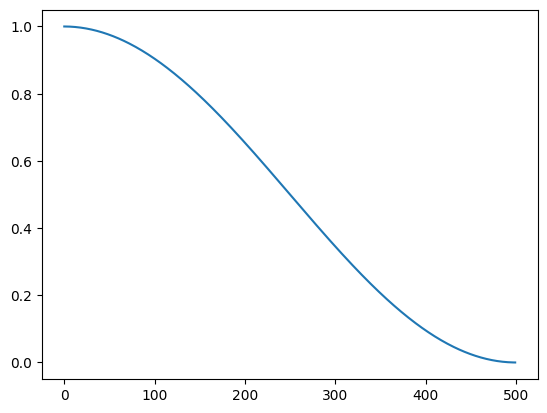

In [9]:
# precache the alpha_bars
a_bar = alphabar_t(torch.arange(0, T), T, S)

plt.plot(a_bar)


In [10]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
loss_fn = torch.nn.HuberLoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-6)

In [12]:
for i in range(100):
    print_loss = 0

    for noise_img, eps, img, t in train_dl:


        noise_img = noise_img.to(device)
        eps = eps.to(device)
        t = t.to(device)

        net.train()

        out = net(noise_img, t)

        loss = loss_fn(out, eps)

        optim.zero_grad()

        loss.backward()

        optim.step()

        print_loss += loss.item()


        iters += 1

        if iters % ITERS_PRINT == 0:
            l = print_loss / ITERS_PRINT
            print_loss = 0
            print(f"[iter {iters}] loss: {l}")


        if iters % ITERS_GENERATE == 0:
            torch.save(net.state_dict(), f'{MODEL_DIR}/{iters}.pth')
            net.eval()
            with torch.no_grad():
                train_sample(20, T, net, iters, shape=(CHANNELS, IMAGE_SIZE, IMAGE_SIZE), folder=SAMPLE_DIR)


[iter 8420] loss: 0.01629566210322082
[iter 8440] loss: 0.014827442937530577
[iter 8460] loss: 0.004935044073499739
[iter 8480] loss: 0.01421572221443057
[iter 8500] loss: 0.01330356658436358


100%|██████████| 499/499 [00:39<00:00, 12.52it/s]


[iter 8520] loss: 0.009980430454015731
[iter 8540] loss: 0.012552080443128943
[iter 8560] loss: 0.001997753931209445
[iter 8580] loss: 0.013826622487977147
[iter 8600] loss: 0.013364363554865121


100%|██████████| 499/499 [00:39<00:00, 12.75it/s]


[iter 8620] loss: 0.007394376536831259
[iter 8640] loss: 0.013907459285110235
[iter 8660] loss: 0.014124198770150542
[iter 8680] loss: 0.014170554745942355
[iter 8700] loss: 0.012892831163480879


100%|██████████| 499/499 [00:39<00:00, 12.64it/s]


[iter 8720] loss: 0.006982813635841012
[iter 8740] loss: 0.0165693873539567
[iter 8760] loss: 0.013304235553368926
[iter 8780] loss: 0.0104179497808218
[iter 8800] loss: 0.013510689325630664


100%|██████████| 499/499 [00:39<00:00, 12.78it/s]


[iter 8820] loss: 0.004222515225410462
[iter 8840] loss: 0.013743947632610798
[iter 8860] loss: 0.013686298904940487
[iter 8880] loss: 0.008137958077713846
[iter 8900] loss: 0.014992170641198755


100%|██████████| 499/499 [00:38<00:00, 12.81it/s]


[iter 8920] loss: 0.013606499414891005
[iter 8940] loss: 0.014865247113630176
[iter 8960] loss: 0.01574716391041875
[iter 8980] loss: 0.005708794668316841
[iter 9000] loss: 0.014140817755833267


100%|██████████| 499/499 [00:38<00:00, 12.82it/s]


[iter 9020] loss: 0.014981018146499991
[iter 9040] loss: 0.011586780566722155
[iter 9060] loss: 0.01502160425297916
[iter 9080] loss: 0.0025910640601068736
[iter 9100] loss: 0.013687421497888864


100%|██████████| 499/499 [00:38<00:00, 12.84it/s]


[iter 9120] loss: 0.014396854350343347
[iter 9140] loss: 0.008955388935282827
[iter 9160] loss: 0.01351432572118938
[iter 9180] loss: 0.01569239590317011
[iter 9200] loss: 0.014978030184283852


100%|██████████| 499/499 [00:38<00:00, 12.84it/s]


[iter 9220] loss: 0.013189190067350864
[iter 9240] loss: 0.005113715259358287
[iter 9260] loss: 0.015863243397325276
[iter 9280] loss: 0.013523965096101164
[iter 9300] loss: 0.012673937203362583


100%|██████████| 499/499 [00:38<00:00, 12.86it/s]


[iter 9320] loss: 0.015373592497780919
[iter 9340] loss: 0.0024029319174587727
[iter 9360] loss: 0.014405145496129989
[iter 9380] loss: 0.014330446952953935
[iter 9400] loss: 0.007615798013284802


100%|██████████| 499/499 [00:38<00:00, 12.83it/s]


[iter 9420] loss: 0.013710231962613761
[iter 9440] loss: 0.01307153725065291
[iter 9460] loss: 0.012871436728164553
[iter 9480] loss: 0.014116280898451804
[iter 9500] loss: 0.005743285967037081


100%|██████████| 499/499 [00:39<00:00, 12.75it/s]


[iter 9520] loss: 0.0140179097186774
[iter 9540] loss: 0.014317694632336498


KeyboardInterrupt: 